In [9]:
import tensorflow as tf
import keras
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

IMAGE_SHAPE = (299, 299)
NUM_CLASSES = 4
preloaded = False
preloaded_path = './Models/saved_engagement_model_2/variables/variables.data-00000-of-00001'

In [2]:
train_path = './MidFrameDataSet/Train/'
val_path = './MidFrameDataSet/Validation/'
test_path = './MidFrameDataSet/Test/'

labels = pd.read_csv('./MidFrameDataSet/labels.csv')
labels

,Unnamed: 0,Boredom,Engagement,Confusion,Frustration,ImageID
0,0,0,2,0,0,1100011002.jpg
1,1,0,2,0,0,1100011003.jpg
2,2,0,3,0,0,1100011004.jpg
3,3,0,3,0,0,1100011005.jpg
4,4,0,3,0,0,1100011006.jpg
...,...,...,...,...,...,...
8920,8920,1,3,0,0,9877360164.jpg
8921,8921,0,3,0,0,9877360165.jpg
8922,8922,1,3,0,2,9877360166.jpg
8923,8923,1,3,1,1,9877360168.jpg


In [3]:
def get_label(imageID):
    success = True
    row = labels.loc[labels['ImageID'] == imageID]
    b, e, c, f = None, None, None, None
    try:
        b = row['Boredom'].iloc[0]
        e = row['Engagement'].iloc[0]
        c = row['Confusion'].iloc[0]
        f = row['Frustration'].iloc[0]
    except:
        success = False
    return np.array([b, e, c, f]), success

def data_load(path):
    print("Starting...")
    x, y = [], []
    for file in os.listdir(path):
        if file[0] == '.':
            continue
        im = cv2.imread(path + file)
        im = cv2.resize(im, IMAGE_SHAPE)
        im = tf.keras.utils.normalize(im)
        lab, success = get_label(file)
        if not success:
            continue
        x.append(im)
        y.append(lab)
    print("Done.")
    return np.array(x), np.array(y)

In [4]:
x_train, y_train = data_load(train_path)
x_val, y_val = data_load(val_path)
x_test, y_test = data_load(test_path)

Starting...
Done.
Starting...
Done.
Starting...
Done.


In [5]:
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [10]:
classifier_url = 'https://tfhub.dev/google/imagenet/inception_v3/classification/4'
do_fine_tuning = True
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SHAPE + (3,)),
    hub.KerasLayer(classifier_url, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(NUM_CLASSES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='softmax')
])
model.layers[0].trainable = False
model.build((None,)+IMAGE_SHAPE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              23853833  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1001)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4008      
Total params: 23,857,841
Trainable params: 4,008
Non-trainable params: 23,853,833
_________________________________________________________________


In [11]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [12]:
steps_per_epoch = 64
validation_steps = 64
hist = model.fit(
    x=x_train, y=y_train,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps).history

Epoch 1/5
64/64 [==============================] - 521s 8s/step - loss: 435.6448 - accuracy: 0.7555 - val_loss: 2509.7007 - val_accuracy: 0.6407
Epoch 2/5
64/64 [==============================] - 462s 7s/step - loss: 2753.3861 - accuracy: 0.7954 - val_loss: 5350.2324 - val_accuracy: 0.6407
Epoch 3/5
64/64 [==============================] - 441s 7s/step - loss: 5266.7250 - accuracy: 0.7861 - val_loss: 8199.3525 - val_accuracy: 0.6407
Epoch 4/5
64/64 [==============================] - 440s 7s/step - loss: 7702.3399 - accuracy: 0.7956 - val_loss: 11026.4736 - val_accuracy: 0.6407
Epoch 5/5
64/64 [==============================] - 432s 7s/step - loss: 10065.3425 - accuracy: 0.8002 - val_loss: 13887.4873 - val_accuracy: 0.6407


In [13]:
count = 1
for item in os.listdir("./Models"):
    count += 1
saved_model_path = f"./Models/saved_engagement_model_" + str(count) + ".h5"
# tf.saved_model.save(model, saved_model_path)
model.save(saved_model_path)

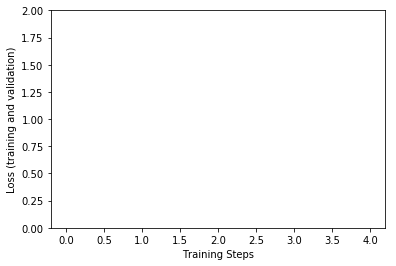

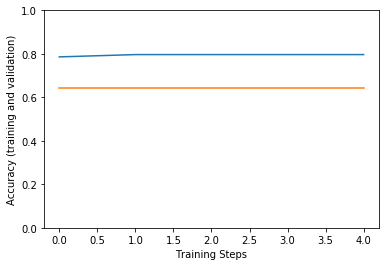

In [14]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
test_hist = model.evaluate(
    x=x_test, y=y_test, batch_size=None, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False,
    return_dict=False
)

49/54 [==========================>...] - ETA: 9s - loss: 11086.0332 - accuracy: 0.7857 